In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib
import os
import xgboost as xgb
import shap

from scripts.dataLoader import dataLoaderParallel

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [22]:
# feature parameters
SIGNAL_FEATURE = ['mbp', 'sbp', 'dbp', 'hr', 'rr', 'spo2', 'etco2', 'mac', 'pp_ct']
STATIC_FEATURE = ["age", "bmi", "asa", "preop_cr", "preop_htn"]
HALF_TIME_FILTERING = [10, 60, 5*60] # secondes

# model parameters
N_ESTIMATORS = 100
MAX_DEPTH = 5
LEARNING_RATE = 0.1
LAMBDA = 7
MIN_CHILD_WEIGHT = 8
ROUND_NUMBER = 75
OBJECTIVE = 'binary:logistic'
METRIC = 'auc'

In [23]:
# test if raw file exists
if not os.path.exists('data/data_async.csv'):
    print('data_async.csv does not exist, please run dataset_download.py first')
    exit()
    
if not os.path.exists('data/data_xbg.csv'):
    dataframe = dataLoaderParallel(
        half_times= HALF_TIME_FILTERING,
        signal_name=SIGNAL_FEATURE,
        static_data=STATIC_FEATURE,
        max_number_of_case=5000,
    )
    dataframe.to_csv('data/data_xbg.csv', index=False)
else:
    dataframe = pd.read_csv('data/data_xbg.csv')

Loading raw data...


Processing caseid: 100%|██████████| 2649/2649 [27:41<00:00,  1.59it/s]  


Number of raw segment: 1054820
Number of selected segment: 165535


cv 0 : 132612 train samples and 32923 test samples, positive rate = 0.04


/home/aubouinb/ownCloud/Code/hypotension_pred/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [23:25:26] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


cv 1 : 132001 train samples and 33534 test samples, positive rate = 0.05


/home/aubouinb/ownCloud/Code/hypotension_pred/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [23:25:27] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


cv 2 : 132006 train samples and 33529 test samples, positive rate = 0.04


/home/aubouinb/ownCloud/Code/hypotension_pred/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [23:25:29] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


cv 3 : 134202 train samples and 31333 test samples, positive rate = 0.04


/home/aubouinb/ownCloud/Code/hypotension_pred/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [23:25:31] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


cv 4 : 131319 train samples and 34216 test samples, positive rate = 0.06


/home/aubouinb/ownCloud/Code/hypotension_pred/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [23:25:33] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


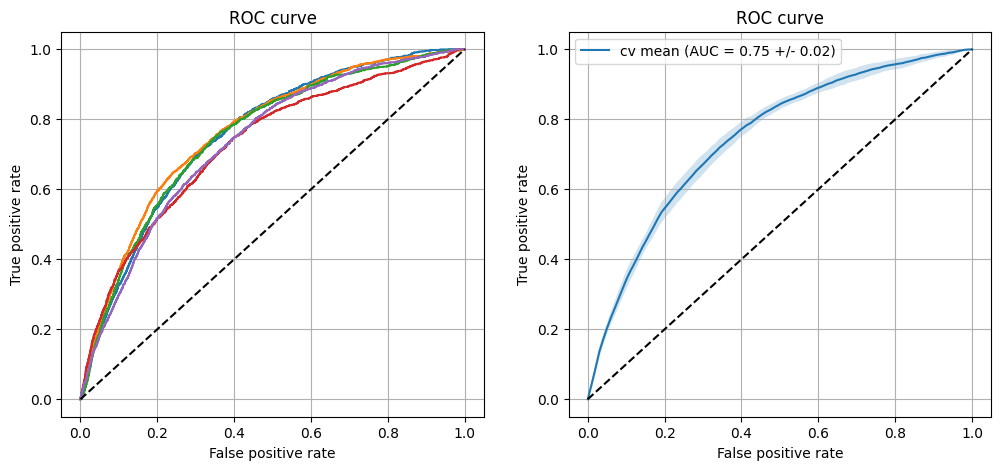

In [27]:
# for each subgoup of data, create a regressor and evaluate it
from sklearn.metrics import auc, roc_curve, roc_auc_score

tpr, fpr, auc  = [], [], []

FEATURE_NAME = [f'{signal}_ema_{half_time}' for signal in SIGNAL_FEATURE for half_time in HALF_TIME_FILTERING] + [f'{signal}_var_{half_time}' for signal in SIGNAL_FEATURE for half_time in HALF_TIME_FILTERING] + STATIC_FEATURE


for cv, test in dataframe.groupby('cv_group'):

    # create a regressor

    train = dataframe[dataframe['cv_group'] != cv]
    train = train.dropna(subset=FEATURE_NAME)
    test = test.dropna(subset=FEATURE_NAME)
    print(f'cv {cv} : {len(train)} train samples and {len(test)} test samples, positive rate = {test["label"].mean():.2f}')

    xgtrain = xgb.DMatrix(train[FEATURE_NAME], label=train['label'])
    xgtest = xgb.DMatrix(test[FEATURE_NAME], label=test['label'])

    param = {'max_depth': MAX_DEPTH, 'objective': OBJECTIVE, 'eval_metric': METRIC,
            'learning_rate': LEARNING_RATE, 'nthread': 4}
    num_round = ROUND_NUMBER

    # Initialize model
    model = xgb.train(param, xgtrain, num_boost_round=num_round, verbose_eval=True)

    #save the model
    model.save_model(f'data/models/xgb_{cv}.model')

    y_pred = model.predict(xgtest)
    y_test = test['label']

    fpr_, tpr_, _ = roc_curve(y_test, y_pred)
    tpr.append(tpr_)
    fpr.append(fpr_)

    auc.append(roc_auc_score(y_test, y_pred))

# plot the ROC curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i in range(len(tpr)):
    plt.plot(fpr[i], tpr[i], label=f'cv {i} (AUC = {auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.grid()

plt.subplot(1, 2, 2)
fpr_mean = np.linspace(0, 1, 100)
tpr_mean = np.zeros(100)
tpr_std = np.zeros(100)
for j in range(len(fpr_mean)):
    tpr_mean[j] = np.mean([np.interp(fpr_mean[j], fpr[i], tpr[i]) for i in range(len(tpr))])
    tpr_std[j] = np.std([np.interp(fpr_mean[j], fpr[i], tpr[i]) for i in range(len(tpr))])

plt.fill_between(fpr_mean, tpr_mean - tpr_std, tpr_mean + tpr_std, alpha=0.2)
plt.plot(fpr_mean, tpr_mean, label=f'cv mean (AUC = {np.mean(auc):.2f} +/- {pd.Series(auc).std():.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.grid()
plt.show()

# save the second figure as a tikz file
plt.figure()
plt.fill_between(fpr_mean, tpr_mean - tpr_std, tpr_mean + tpr_std, alpha=0.2)
plt.plot(fpr_mean, tpr_mean, label=f'cv mean $(AUC = {np.mean(auc):.2f} \pm {pd.Series(auc).std():.2f})$')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.legend(loc='lower right')
plt.grid()
plt.xlim([0, 1])
plt.ylim([0, 1])


param = ['legend style={rounded corners=0.5mm, font=\\footnotesize}']

# tikzplotlib.save("./report/figures/xgboost_roc.tex", extra_axis_parameters=param)
plt.close()

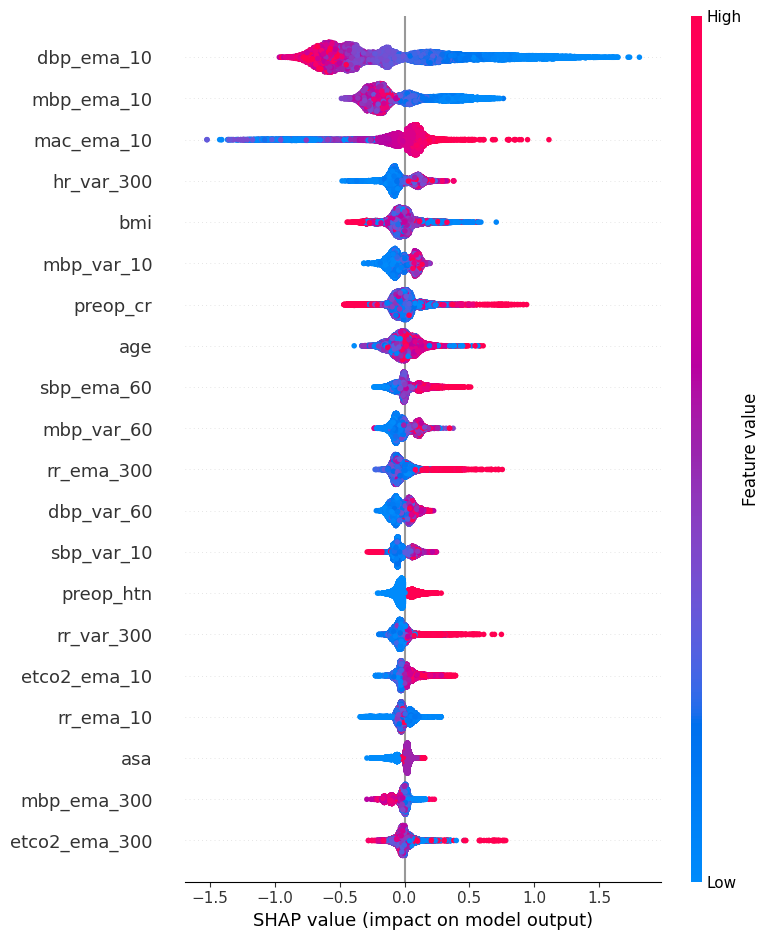

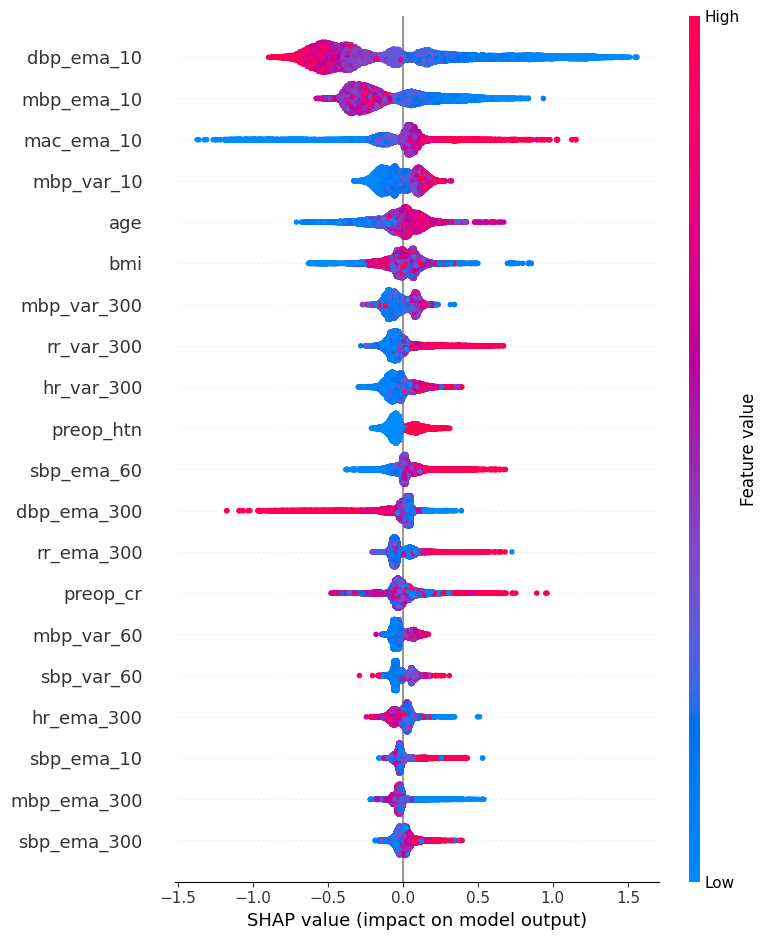

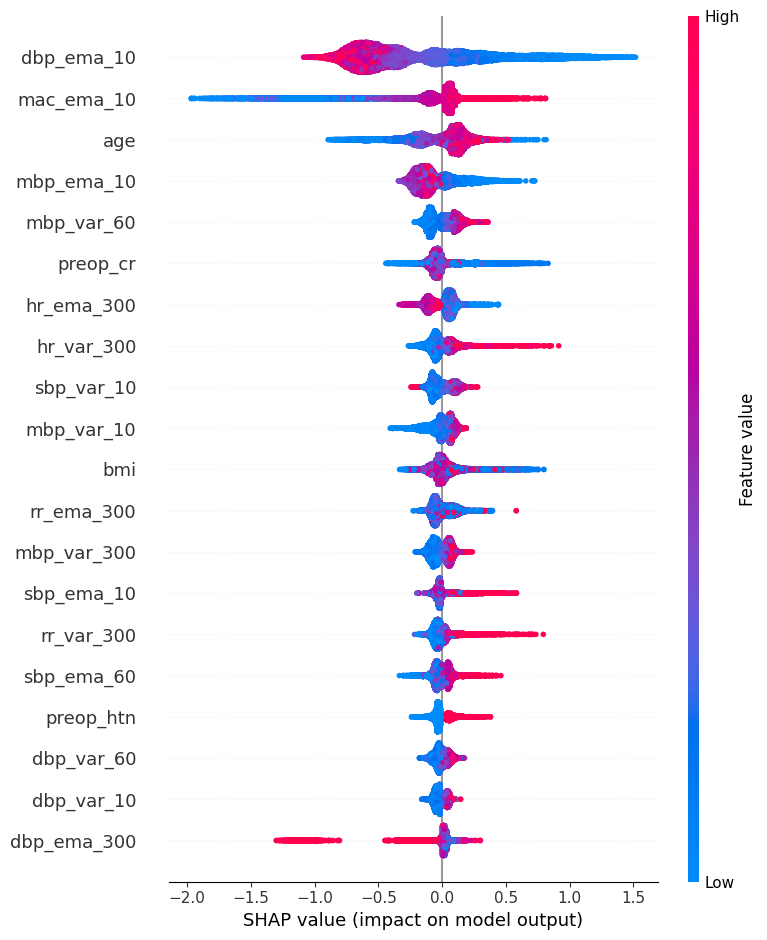

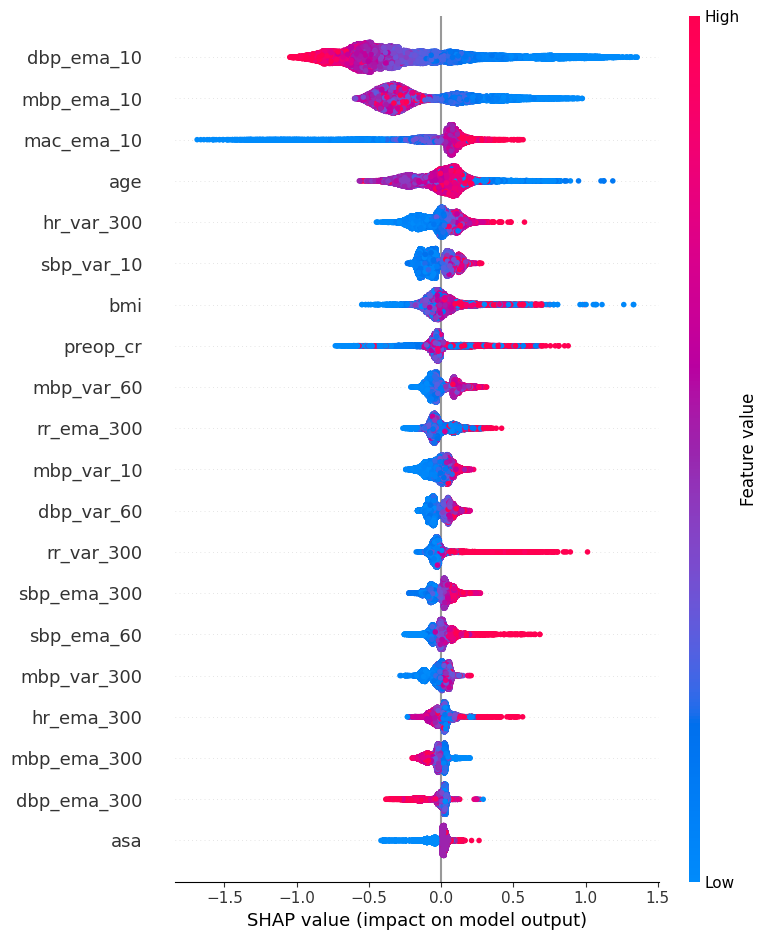

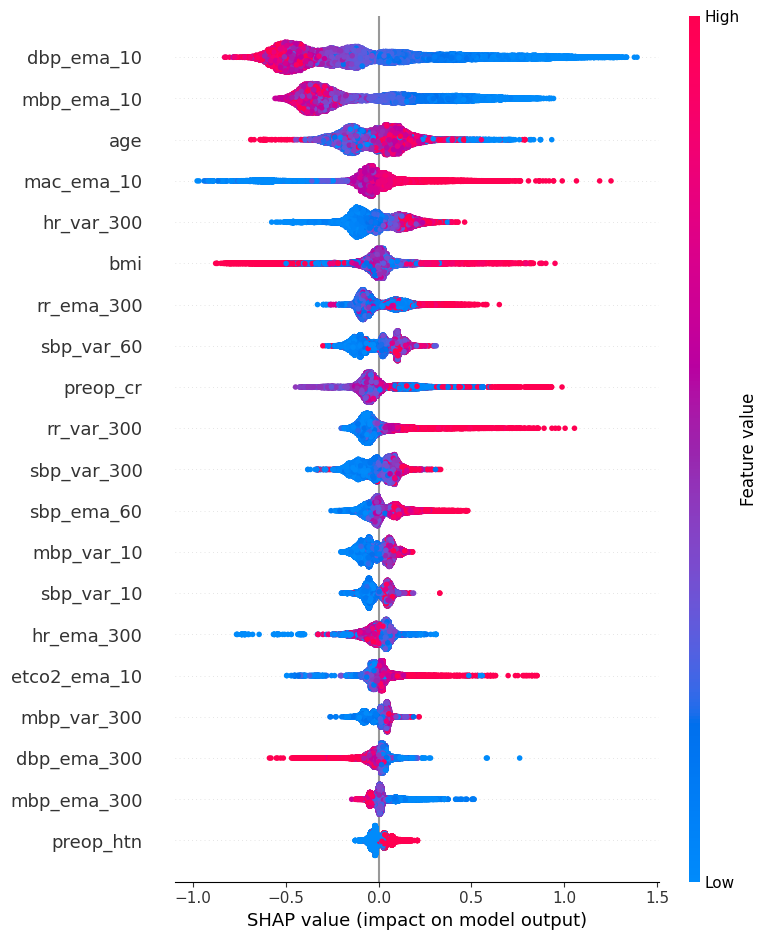

In [30]:
# use SHAP to explain the model
shap.initjs()
for cv, test in dataframe.groupby('cv_group'):
    model = xgb.Booster()
    model.load_model(f'data/models/xgb_{cv}.model')
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(test[FEATURE_NAME])
    shap.summary_plot(shap_values, test[FEATURE_NAME], feature_names=FEATURE_NAME, show=False)
    plt.show()